In [2]:
import os
from google.colab import files

# 1. Upload Kaggle API Token
print("Please upload your 'kaggle.json' file:")
uploaded = files.upload()

# 2. Configure Kaggle Directory
# Move the API key to the hidden .kaggle directory for authentication.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print(" Kaggle API configured successfully.")

# 3. Download the Dataset
# Downloading the Chest X-Ray Images (Pneumonia) dataset directly from Kaggle.
print("Downloading dataset... (This may take a minute)")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# 4. Unzip the Dataset
# Unzipping the downloaded file into the current directory.
print("Unzipping dataset...")
!unzip -q chest-xray-pneumonia.zip
print("🎉 Dataset is ready for processing!")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
 Kaggle API configured successfully.
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:37<00:03, 16.6MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.7MB/s]
Unzipping dataset...
🎉 Dataset is ready for processing!


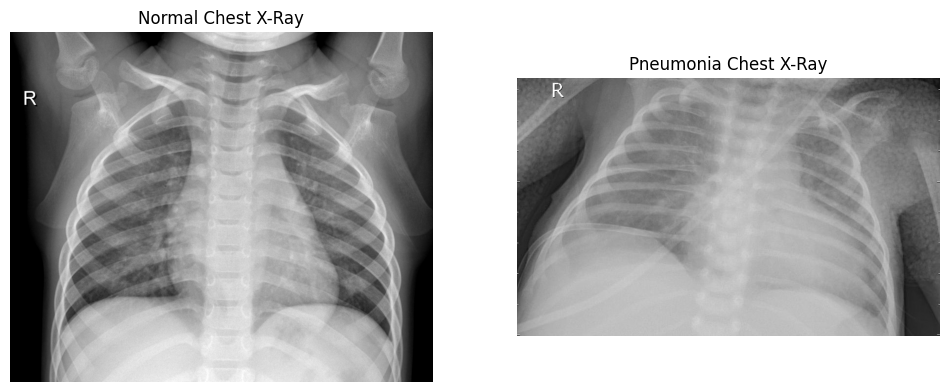

Normal Image Shape: (1473, 1778)
Pneumonia Image Shape: (528, 864)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define dataset directories
base_dir = 'chest_xray/train'
normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

# Retrieve the first image filename from each category
normal_img_name = os.listdir(normal_dir)[0]
pneumonia_img_name = os.listdir(pneumonia_dir)[0]

# Load the images using Matplotlib
img_normal = mpimg.imread(os.path.join(normal_dir, normal_img_name))
img_pneumonia = mpimg.imread(os.path.join(pneumonia_dir, pneumonia_img_name))

# Plotting the images side by side
plt.figure(figsize=(12, 6))

# Subplot 1: Normal Case
plt.subplot(1, 2, 1)
plt.imshow(img_normal, cmap='gray')
plt.title("Normal Chest X-Ray")
plt.axis('off')

# Subplot 2: Pneumonia Case
plt.subplot(1, 2, 2)
plt.imshow(img_pneumonia, cmap='gray')
plt.title("Pneumonia Chest X-Ray")
plt.axis('off')

plt.show()

# Print image dimensions to understand input shape
print(f"Normal Image Shape: {img_normal.shape}")
print(f"Pneumonia Image Shape: {img_pneumonia.shape}")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define Data Generators (Scaling pixel values to range 0-1)
# We rescale the images by dividing by 255.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Load Images from Directory
base_dir = 'chest_xray'

print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'      # Binary classification: Normal vs Pneumonia
)

print("\nLoading Validation Data:")
val_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print("\nLoading Test Data:")
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Loading Training Data:
Found 5216 images belonging to 2 classes.

Loading Validation Data:
Found 16 images belonging to 2 classes.

Loading Test Data:
Found 624 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# 1. Initialize the CNN
model = Sequential()

# 2. Input Layer (Define the image shape explicitly here)
# This is the modern, correct way to start a model in Keras
model.add(Input(shape=(150, 150, 3)))

# 3. Convolutional Layers (The "Eyes")
# Layer 1: Detect basic features
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Layer 2: Detect shapes
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Layer 3: Detect complex features (like pneumonia opacity)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# 4. Flattening (Convert to 1D vector)
model.add(Flatten())

# 5. Fully Connected Layers (The "Brain")
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Randomly drop 50% of neurons to prevent memorization

# 6. Output Layer (Binary Classification: 0 or 1)
model.add(Dense(1, activation='sigmoid'))

# 7. Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# 8. Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 1. Train the Model
# This process might take 5-10 minutes depending on Google Colab's speed.
print("Training Started... Please wait ☕")

history = model.fit(
    train_generator,
    steps_per_epoch=163, # 5216 images / 32 batch size = 163 steps
    epochs=5,            # Number of passes through the entire dataset
    validation_data=test_generator,
    validation_steps=20  # 624 images / 32 batch size = ~20 steps
)

print("🎉 Training Completed!")

Training Started... Please wait ☕


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.7979 - loss: 0.4893 - recall: 0.9169 - val_accuracy: 0.7933 - val_loss: 0.7441 - val_recall: 0.9923
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.9636 - loss: 0.1005 - recall: 0.9762 - val_accuracy: 0.7965 - val_loss: 0.5532 - val_recall: 0.9872
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9634 - loss: 0.1005 - recall: 0.9761 - val_accuracy: 0.7644 - val_loss: 0.9796 - val_recall: 0.9949
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9751 - loss: 0.0638 - recall: 0.9822 - val_accuracy: 0.7644 - val_loss: 1.2521 - val_recall: 0.9949
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9819 - loss: 0.0527 - recall: 0.9884 - val_accuracy: 0.7436 - val_loss: 1.5125 - val_recall: 0.9949
🎉 Training Completed!


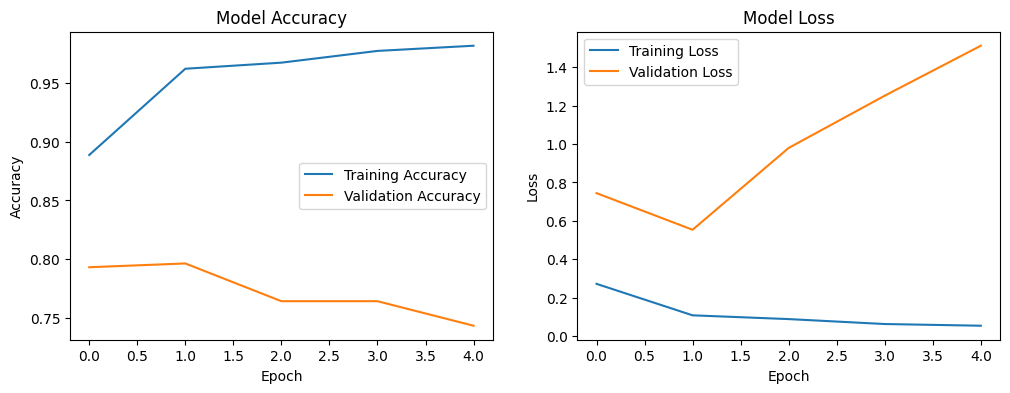

Final Validation Recall: 99.49%


In [7]:
import matplotlib.pyplot as plt

# 1. Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(f"Final Validation Recall: {history.history['val_recall'][-1]*100:.2f}%")

In [8]:
# 1. Evaluate on the Unseen Test Set
print("Running Final Evaluation on Test Set...")

# This step tests the model on the 624 images it has never seen before
eval_result = model.evaluate(test_generator)

print("\n------------------------------------------------")
print(f"📉 Final Test Loss:      {eval_result[0]:.4f}")
print(f"🎯 Final Test Accuracy:  {eval_result[1]*100:.2f}%")
print(f"🩺 Final Test Recall:    {eval_result[2]*100:.2f}%") # This is your CV star metric!
print("------------------------------------------------")

# 2. Save the Model
# Saving the trained model to a file for future use (e.g., in a web app)
model.save('pneumonia_detection_model.h5')
print("\n✅ Model saved successfully as 'pneumonia_detection_model.h5'")

Running Final Evaluation on Test Set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 567ms/step - accuracy: 0.7226 - loss: 1.7271 - recall: 0.9934



------------------------------------------------
📉 Final Test Loss:      1.5125
🎯 Final Test Accuracy:  74.36%
🩺 Final Test Recall:    99.49%
------------------------------------------------

✅ Model saved successfully as 'pneumonia_detection_model.h5'


📄 Analyzing File: IM-0067-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


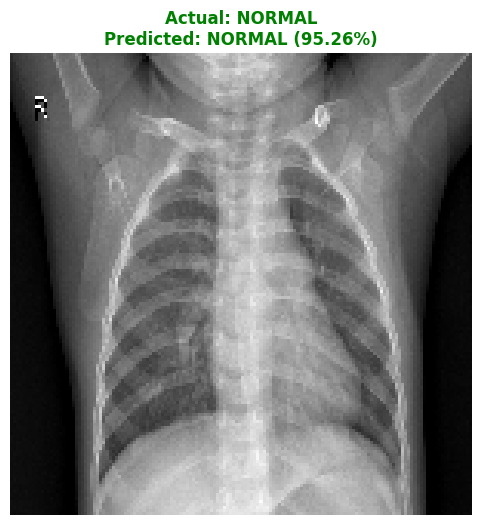

Result: ✅ Correct


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import os

# --- Single Cell Inference Script ---

# 1. Define Test Directory
test_dir = 'chest_xray/test'

# 2. Select a Random Image
# Randomly choose a category (NORMAL or PNEUMONIA)
true_label = random.choice(['NORMAL', 'PNEUMONIA'])
class_dir = os.path.join(test_dir, true_label)

# Select a random file from that category
filename = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, filename)

print(f"📄 Analyzing File: {filename}")

# 3. Preprocess the Image
# Load image with target size 150x150 and RGB mode (to match model input)
img = image.load_img(img_path, target_size=(150, 150), color_mode='rgb')
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

# 4. Make Prediction
prediction = model.predict(img_array)
confidence_score = prediction[0][0]

# 5. Interpret the Result
# Threshold is 0.5: > 0.5 is Pneumonia, <= 0.5 is Normal
if confidence_score > 0.5:
    predicted_label = "PNEUMONIA"
    color = 'red'
    display_score = confidence_score
else:
    predicted_label = "NORMAL"
    color = 'green'
    display_score = 1 - confidence_score

# Check if the prediction matches the reality
match_status = "✅ Correct" if true_label == predicted_label else "❌ Incorrect (False Positive/Negative)"

# 6. Display the Result
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Actual: {true_label}\nPredicted: {predicted_label} ({display_score*100:.2f}%)",
          color=color, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Result: {match_status}")